In [1]:
!pip install pydicom nibabel numpy


[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os

dataset_path = r"C:\Users\muj\Documents\MINORWORK\MRI_Scans_Dataset"  

if os.path.exists(dataset_path):
    print("Dataset found at:", dataset_path)
    print("Folders inside:", os.listdir(dataset_path))
else:
    print("Dataset not found! Check if the upload was successful.")

Dataset found at: C:\Users\muj\Documents\MINORWORK\MRI_Scans_Dataset
Folders inside: ['AD', 'CN', 'EMCI', 'LMCI', 'MCI', 'SMC']


Converting data from DICHOM to NIfTY format

In [3]:
import os
import numpy as np
import pydicom
import nibabel as nib
import cv2
from tqdm import tqdm

input_root = r"C:\Users\muj\Documents\MINORWORK\MRI_Scans_Dataset"
output_root = r"C:\Users\muj\Documents\MINORWORK\MRI_NIfTY_Output"

os.makedirs(output_root, exist_ok=True)

TARGET_SHAPE = (256, 256) 

for category in os.listdir(input_root):
    input_category_folder = os.path.join(input_root, category)

    category_output_folder = os.path.join(output_root, category)
    os.makedirs(category_output_folder, exist_ok=True)

    for entry in os.listdir(input_category_folder):
        entry_path = os.path.join(input_category_folder, entry)

        if os.path.isdir(entry_path):
            output_subfolder_path = os.path.join(category_output_folder, entry)
            os.makedirs(output_subfolder_path, exist_ok=True)

            for file in tqdm(sorted(os.listdir(entry_path)), desc=f"Processing {category}/{entry}"):
                file_path = os.path.join(entry_path, file)
                if file.lower().endswith(".dcm"):  
                    dicom_data = pydicom.dcmread(file_path)
                    pixel_array = dicom_data.pixel_array  

                    resized_array = cv2.resize(pixel_array, TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)

                    nifti_image = nib.Nifti1Image(resized_array[np.newaxis, :, :], affine=np.eye(4))

                    nifti_filename = os.path.splitext(file)[0] + ".nii.gz"
                    nifti_path = os.path.join(output_subfolder_path, nifti_filename)
                    nib.save(nifti_image, nifti_path)

        elif entry.lower().endswith(".dcm"):
            dicom_data = pydicom.dcmread(entry_path)
            pixel_array = dicom_data.pixel_array

            resized_array = cv2.resize(pixel_array, TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)
            nifti_image = nib.Nifti1Image(resized_array[np.newaxis, :, :], affine=np.eye(4))

            nifti_filename = os.path.splitext(entry)[0] + ".nii.gz"
            nifti_path = os.path.join(category_output_folder, nifti_filename)
            nib.save(nifti_image, nifti_path)

    print(f"Completed processing for {category}")
print("\nConversion Completed Successfully!")

Completed processing for AD
Completed processing for CN
Completed processing for EMCI
Completed processing for LMCI
Completed processing for MCI
Completed processing for SMC

Conversion Completed Successfully!


NIfTI Image Shape: (1, 256, 256)


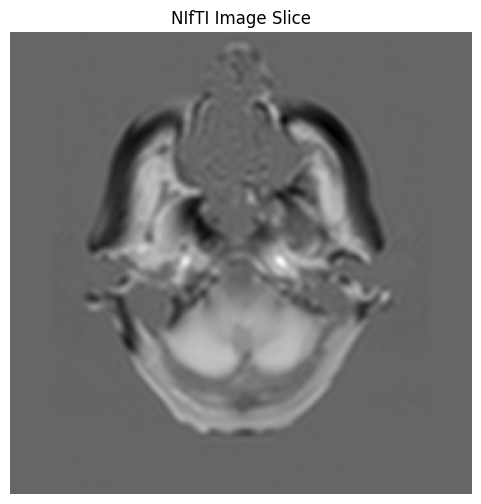

In [4]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

nifti_path = r"C:\Users\muj\Documents\MINORWORK\MRI_NIfTY_Output\AD\ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807153909477_16_S159830_I322003.nii.gz" 
img = nib.load(nifti_path)
data = img.get_fdata() 

print("NIfTI Image Shape:", data.shape)

slice_data = np.squeeze(data) 

plt.figure(figsize=(6, 6))
plt.imshow(slice_data, cmap="gray") 
plt.title("NIfTI Image Slice")
plt.axis("off")
plt.show()

In [5]:
pip install SimpleITK

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install nilearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import os
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import nilearn.image as nli
import matplotlib.pyplot as plt

In [8]:
!pip install nibabel nilearn simpleitk
!apt-get install fsl-core -y


[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


Preprocessing

In [9]:
input_root = r"C:\Users\muj\Documents\MINORWORK\MRI_Scans_Dataset"
output_root = r"C:\Users\muj\Documents\MINORWORK\MRI_NIfTY_Output"
os.makedirs(output_root, exist_ok=True)

In [ ]:
import os
import numpy as np
import nibabel as nib
from nilearn.image import resample_img, smooth_img

#Preprocessing 
def preprocess_mri(input_path, output_path):

    img = nib.load(input_path)
    data = img.get_fdata(dtype=np.float32) 

    #Reorientation 
    reoriented_img = resample_img(
        img, target_affine=img.affine, target_shape=data.shape,
        force_resample=True, copy_header=True  
    )

    #Skull Stripping 
    brain_mask = data > np.percentile(data, 10)  
    skull_stripped_data = data * brain_mask

    #Normalization 
    skull_stripped_data = (skull_stripped_data - np.min(skull_stripped_data)) / (np.max(skull_stripped_data) - np.min(skull_stripped_data))
    skull_stripped_data = skull_stripped_data.astype(np.float32)  

    #Registration 
    registered_img = resample_img(
        nib.Nifti1Image(skull_stripped_data, img.affine),
        target_affine=img.affine, force_resample=True, copy_header=True
    )

    #Smoothing
    smoothed_img = smooth_img(registered_img, fwhm=3) 

    #Segmentation 
    segmented_data = np.where(skull_stripped_data > 0.5, 1, 0).astype(np.float32)  

    #Save Preprocessed Image
    preprocessed_img = nib.Nifti1Image(segmented_data, img.affine)
    nib.save(preprocessed_img, output_path)

    return output_path

input_root = r"C:\Users\muj\Documents\MINORWORK\MRI_NIfTY_Output"
output_root = r"C:\Users\muj\Documents\MINORWORK\MRI_Preprocessed_Output"

if not os.path.exists(input_root):
    raise FileNotFoundError(f"Input folder '{input_root}' not found!")

for category in os.listdir(input_root):
    input_folder = os.path.join(input_root, category)
    output_folder = os.path.join(output_root, category)
    os.makedirs(output_folder, exist_ok=True) 

    for filename in os.listdir(input_folder):
        if filename.endswith(".nii") or filename.endswith(".nii.gz"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            try:
                preprocess_mri(input_path, output_path)
                print(f"Processed: {output_path}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

print("Preprocessing Complete!")

Processed: C:\Users\muj\Documents\MINORWORK\MRI_Preprocessed_Output\AD\ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807153909477_16_S159830_I322003.nii.gz
Processed: C:\Users\muj\Documents\MINORWORK\MRI_Preprocessed_Output\AD\ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807153928733_14_S159830_I322003.nii.gz
Processed: C:\Users\muj\Documents\MINORWORK\MRI_Preprocessed_Output\AD\ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807153938319_116_S159830_I322003.nii.gz
Processed: C:\Users\muj\Documents\MINORWORK\MRI_Preprocessed_Output\AD\ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807153946302_156_S159830_I322003.nii.gz
Processed: C:\Users\muj\Documents\MINORWORK\MRI_Preprocessed_Output\AD\ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807153956230_56_S159830_I322003.nii.gz
Processed: C:\Users\muj\Documents\MINORWORK\MRI_Preprocessed_Output\AD\ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807153959925_20_S159830_I322003.nii.gz
Processed: C:\Users\muj\Documents\MINORWORK\MRI_Preprocessed_O

Feature Extraction

In [3]:
!pip install nibabel numpy scipy scikit-image pyradiomics

  Using cached pyradiomics-3.1.0.tar.gz (34.5 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: filename has '3.1.0', but metadata has '3.0.1a1'
  Using cached pyradiomics-3.0.1.tar.gz (34.5 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyradiomics: filename=pyra


[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import numpy as np
import nibabel as nib
import os
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained DenseNet-121 and modify for feature extraction
model = models.densenet121(pretrained=True)
model.classifier = nn.Identity()  
model = model.to(device).eval()  

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_features(nifti_path, batch_size=32):
    """Extracts features from NIfTI MRI slices using DenseNet-121."""
    try:
        img = nib.load(nifti_path)
        data = img.get_fdata()

        slices = []
        for slice_idx in range(data.shape[2]):
            slice_data = data[:, :, slice_idx]
            slice_data = (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data))  
            slice_data = (slice_data * 255).astype(np.uint8)
            slice_image = Image.fromarray(slice_data).convert("RGB")
            slice_tensor = preprocess(slice_image)
            slices.append(slice_tensor)

        batch = torch.stack(slices).to(device)

        features = []
        with torch.no_grad():
            for i in range(0, len(batch), batch_size):
                batch_slice = batch[i:i + batch_size]
                output = model(batch_slice)
                features.append(output.cpu().numpy())

        features = np.concatenate(features, axis=0)
        features = np.mean(features, axis=0)
        return features.flatten() 

    except Exception as e:
        print(f"Error processing {nifti_path}: {e}")
        return None

nifti_root = r"C:\Users\muj\Documents\MINORWORK\MRI_Preprocessed_Output"
nifti_files = []

for category in os.listdir(nifti_root):
    category_path = os.path.join(nifti_root, category)
    if os.path.isdir(category_path):
        for file in os.listdir(category_path):
            if file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(category_path, file))

start_time = time.time()
all_features = {}

for nifti_file in nifti_files:
    features = extract_features(nifti_file, batch_size=64)
    if features is not None:
        all_features[nifti_file] = features

end_time = time.time()
print(f"Feature extraction completed in {end_time - start_time:.2f} seconds")
print(all_features)

densenet_feature_array = np.array(list(all_features.values()), dtype=object)
np.save("densenet_features.npy", densenet_feature_array)
print("Features saved as densenet_features.npy")

Using device: cuda


C:\Users\muj\AppData\Local\Temp\ipykernel_5944\3252611439.py:37: RuntimeWarning: invalid value encountered in divide
  slice_data = (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data))  # Normalize
C:\Users\muj\AppData\Local\Temp\ipykernel_5944\3252611439.py:38: RuntimeWarning: invalid value encountered in cast
  slice_data = (slice_data * 255).astype(np.uint8)


Feature extraction completed in 233.14 seconds
{'C:\\Users\\muj\\Documents\\MINORWORK\\MRI_Preprocessed_Output\\AD\\ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807153909477_16_S159830_I322003.nii.gz': array([1.4537801e-04, 5.8723460e-03, 1.4238714e-03, ..., 1.6756490e-01,
       3.3336446e-01, 6.2784657e-02], dtype=float32), 'C:\\Users\\muj\\Documents\\MINORWORK\\MRI_Preprocessed_Output\\AD\\ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807153928733_14_S159830_I322003.nii.gz': array([1.4041433e-04, 5.7747532e-03, 1.3706167e-03, ..., 1.9455807e-01,
       2.6378205e-01, 5.9224993e-02], dtype=float32), 'C:\\Users\\muj\\Documents\\MINORWORK\\MRI_Preprocessed_Output\\AD\\ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807153938319_116_S159830_I322003.nii.gz': array([1.4942369e-04, 4.3777339e-03, 1.5713944e-03, ..., 1.1257543e-01,
       2.2608048e-01, 3.8949247e-02], dtype=float32), 'C:\\Users\\muj\\Documents\\MINORWORK\\MRI_Preprocessed_Output\\AD\\ADNI_006_S_4867_MR_Field_Mapping__br_raw

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import numpy as np
import nibabel as nib
import os
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.inception_v3(pretrained=True)
model.fc = nn.Identity()  
model.eval()
model = model.to(device)

# Define preprocessing pipeline - InceptionV3 requires 299x299 input
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_features(nifti_path, batch_size=32):
    try:
        
        img = nib.load(nifti_path)
        data = img.get_fdata()

        if data.size == 0:
            print(f"Skipping {nifti_path}: Empty file!")
            return None

        slices = []
        for slice_idx in range(data.shape[2]):
            slice_data = data[:, :, slice_idx]
            slice_data = (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data) + 1e-5) 
            slice_data = (slice_data * 255).astype(np.uint8)  
            slice_image = Image.fromarray(slice_data).convert("RGB") 
            slice_tensor = preprocess(slice_image)
            slices.append(slice_tensor)

        batch = torch.stack(slices).to(device)

        features = []
        with torch.no_grad():
            for i in range(0, len(batch), batch_size):
                batch_slice = batch[i:i + batch_size]
                output = model(batch_slice)
                features.append(output.cpu().numpy())

        features = np.concatenate(features, axis=0)
        feature_vector = np.mean(features, axis=0) 
        return feature_vector

    except Exception as e:
        print(f"Error processing {nifti_path}: {str(e)}")
        return None

nifti_root = r"C:\Users\muj\Documents\MINORWORK\MRI_Preprocessed_Output"
nifti_files = [
    os.path.join(root, file)
    for root, _, files in os.walk(nifti_root)
    for file in files if file.endswith(".nii.gz")
]

start_time = time.time()
extracted_features = []

for idx, nifti_file in enumerate(nifti_files):
    print(f"Processing {idx+1}/{len(nifti_files)}: {os.path.basename(nifti_file)}")
    features = extract_features(nifti_file)

    if features is not None:
        extracted_features.append(features)

end_time = time.time()

if extracted_features:
    extracted_features = np.array(extracted_features)
    np.save("inception_features.npy", extracted_features)
    print(f"Saved {len(extracted_features)} feature vectors.")
    print(f"Final feature shape: {extracted_features.shape}")
else:
    print("No valid features extracted! Check the input data.")

print(f"Feature extraction completed in {end_time - start_time:.2f} seconds")

Using device: cuda


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processing 1/600: ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807153909477_16_S159830_I322003.nii.gz
Processing 2/600: ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807153928733_14_S159830_I322003.nii.gz
Processing 3/600: ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807153938319_116_S159830_I322003.nii.gz
Processing 4/600: ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807153946302_156_S159830_I322003.nii.gz
Processing 5/600: ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807153956230_56_S159830_I322003.nii.gz
Processing 6/600: ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807153959925_20_S159830_I322003.nii.gz
Processing 7/600: ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807154014144_74_S159830_I322003.nii.gz
Processing 8/600: ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807154016208_24_S159830_I322003.nii.gz
Processing 9/600: ADNI_006_S_4867_MR_Field_Mapping__br_raw_20120807154033089_154_S159830_I322003.nii.gz
Processing 10/600: ADNI_006_S_4867_MR_Field_Mapping__br_raw_2012080715

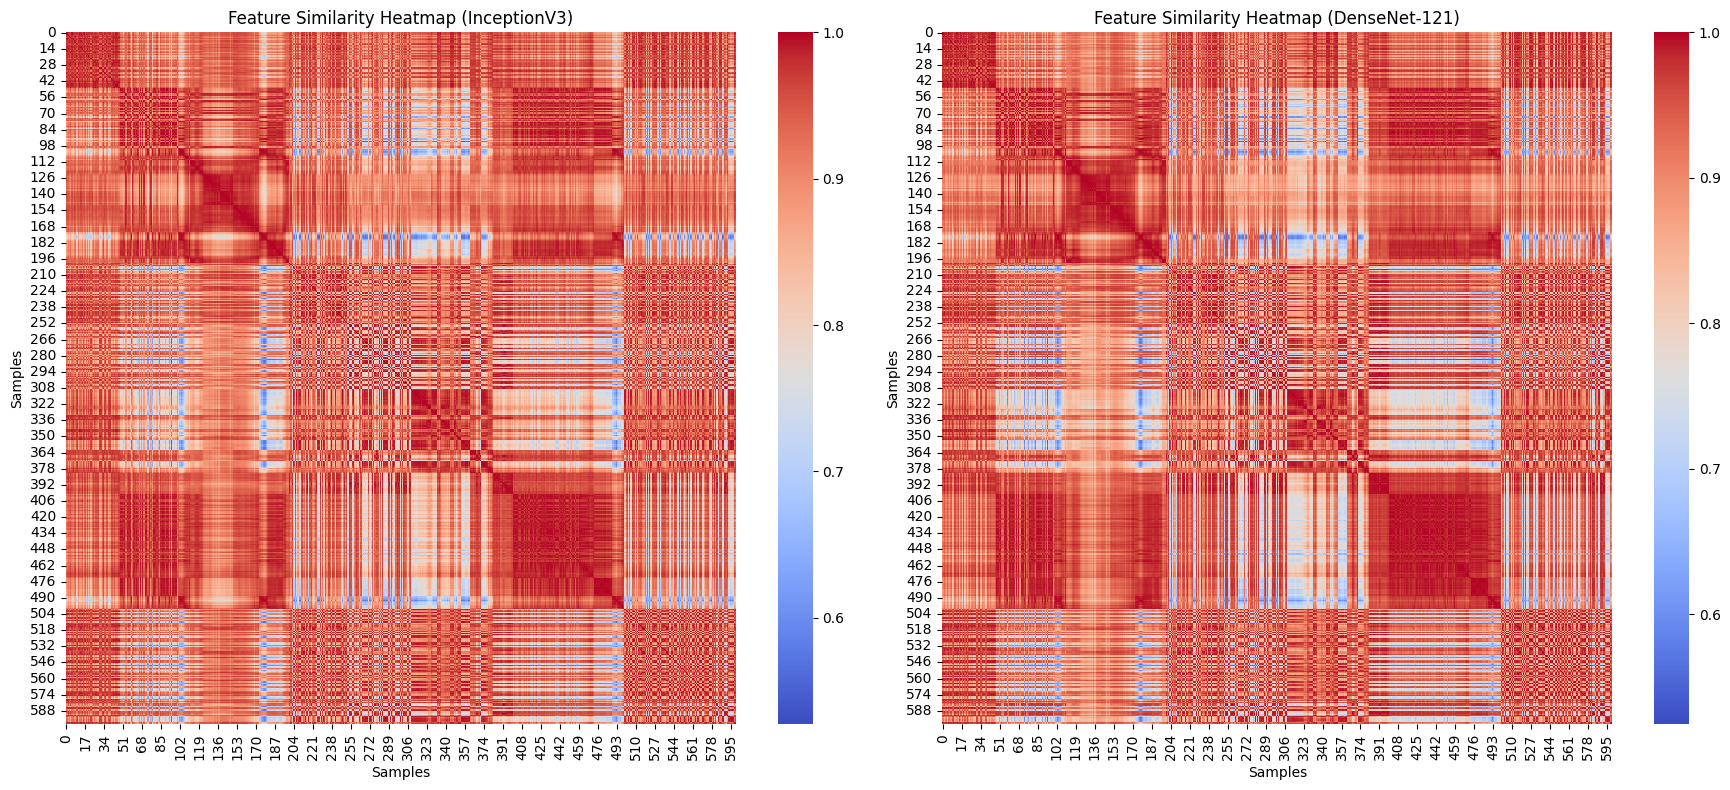

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

inception_features = np.load("inception_features.npy", allow_pickle=True)
densenet_features = np.load("densenet_features.npy", allow_pickle=True)

def process_features(features):
    if isinstance(features, dict):
        feature_list = [value for key, value in features.items() if isinstance(value, np.ndarray)]
        if not feature_list:
            raise ValueError("No valid feature arrays found!")
        return np.array(feature_list)

    elif isinstance(features, np.ndarray):
        return features 

    else:
        raise TypeError("Unexpected file format! Must be a dictionary or NumPy array.")

inception_features = process_features(inception_features)
densenet_features = process_features(densenet_features)

if inception_features.shape[1] != densenet_features.shape[1]:
    min_features = min(inception_features.shape[1], densenet_features.shape[1])
    inception_features = inception_features[:, :min_features]
    densenet_features = densenet_features[:, :min_features]

inception_similarity = cosine_similarity(inception_features)
densenet_similarity = cosine_similarity(densenet_features)

# Plot heatmaps 
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.heatmap(inception_similarity, cmap="coolwarm", annot=False, ax=axes[0])
axes[0].set_title("Feature Similarity Heatmap (InceptionV3)")
axes[0].set_xlabel("Samples")
axes[0].set_ylabel("Samples")

sns.heatmap(densenet_similarity, cmap="coolwarm", annot=False, ax=axes[1])
axes[1].set_title("Feature Similarity Heatmap (DenseNet-121)")
axes[1].set_xlabel("Samples")
axes[1].set_ylabel("Samples")

plt.tight_layout()
plt.show()

train_images.shape: (480, 2048)
train_labels.shape: (480,)
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.4764 - loss: 1.1395 - val_accuracy: 0.4833 - val_loss: 0.7005 - learning_rate: 1.0000e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5197 - loss: 0.8678 - val_accuracy: 0.4833 - val_loss: 0.7184 - learning_rate: 1.0000e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5092 - loss: 1.0057 - val_accuracy: 0.4833 - val_loss: 0.7321 - learning_rate: 1.0000e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5335 - loss: 0.9028 - val_accuracy: 0.4833 - val_loss: 0.7484 - learning_rate: 1.0000e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5408 - loss: 0.8523 - val_accuracy: 0.4833 - val_loss: 0.7413 - learning_rate: 1.0000e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5554 - loss: 0.9033 - val_accuracy: 0.4833 - val_loss: 0.8306 - learning_rate: 1.0000e-04
Epoch

c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

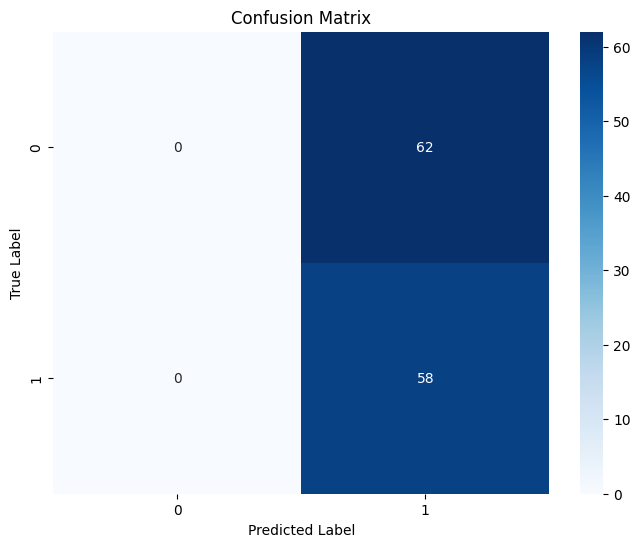

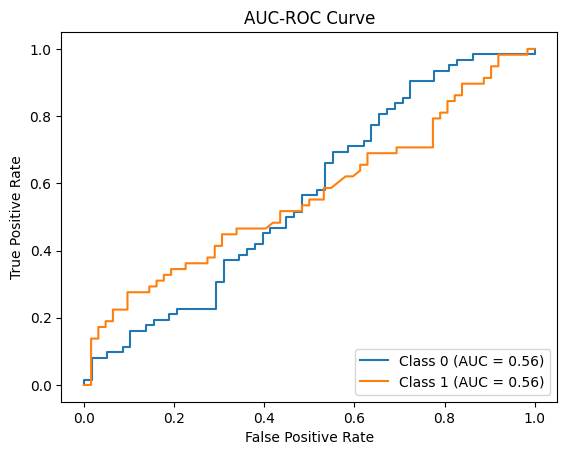

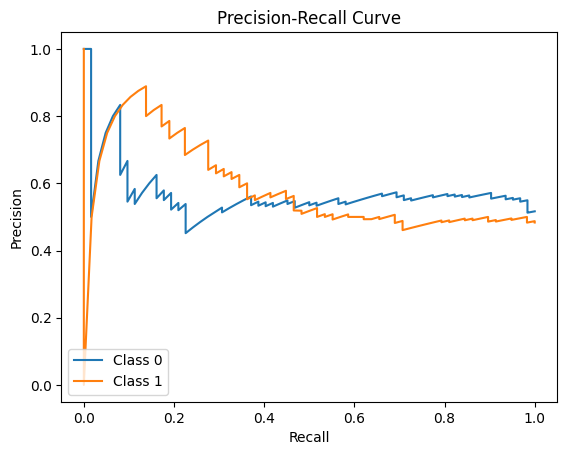

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

train_images = np.load("train_inception.npy", allow_pickle=True)  
test_images = np.load("test_inception.npy", allow_pickle=True)   
train_labels = np.load("train_labels.npy", allow_pickle=True)
test_labels = np.load("test_labels.npy", allow_pickle=True)

print(f"train_images.shape: {train_images.shape}")
print(f"train_labels.shape: {train_labels.shape}")

# One-hot encode the labels
num_classes = len(np.unique(train_labels))
train_labels_categorical = to_categorical(train_labels, num_classes)
test_labels_categorical = to_categorical(test_labels, num_classes)

# Matching dimensions
assert train_images.shape[0] == train_labels_categorical.shape[0], "Mismatch in training data"
assert test_images.shape[0] == test_labels_categorical.shape[0], "Mismatch in test data"

# Reshape input arrays to match the CoAtNet model's expected 4D input (batch_size, height, width, channels)
train_images = np.reshape(train_images, (train_images.shape[0], 32, 64, 1))  
test_images = np.reshape(test_images, (test_images.shape[0], 32, 64, 1))
input_shape = (32, 64, 1)

def coatnet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Initial Convolutional Stem Layer (Feature Extraction)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # CoAtNet-Like Blocks with Convolutions and Attention Mechanisms
    for _ in range(2):  # Block 1: Convolutional focus
        x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)  # Block 2: Attention
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)  # Block 3: Hybrid
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


model = coatnet_model(input_shape=input_shape, num_classes=num_classes)

# Callbacks to prevent overfitting and improve training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

batch_size = 16
history = model.fit(
    train_images, train_labels_categorical,
    validation_data=(test_images, test_labels_categorical),
    epochs=100,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

test_loss, test_accuracy = model.evaluate(test_images, test_labels_categorical)
print(f"\nTest Accuracy: {test_accuracy:.2f}")

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_categorical, axis=1)

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

plt.figure()
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(test_labels_categorical[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend(loc="lower right")
plt.show()

plt.figure()
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(test_labels_categorical[:, i], predictions[:, i])
    plt.plot(recall, precision, label=f"Class {i}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


train_images.shape: (480, 2048)
train_labels.shape: (480,)
Epoch 1/100


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4660 - loss: 1.0749 - val_accuracy: 0.4833 - val_loss: 0.7068 - learning_rate: 1.0000e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4973 - loss: 0.9119 - val_accuracy: 0.4833 - val_loss: 0.7227 - learning_rate: 1.0000e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5703 - loss: 0.8534 - val_accuracy: 0.4833 - val_loss: 0.7231 - learning_rate: 1.0000e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5197 - loss: 0.8567 - val_accuracy: 0.4833 - val_loss: 0.7308 - learning_rate: 1.0000e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5499 - loss: 0.9328 - val_accuracy: 0.4750 - val_loss: 0.7272 - learning_rate: 1.0000e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5538 - loss: 0.8491 - val_accuracy: 0.4833 - val_loss: 0.7653 - learning_rate: 1.0000e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5656 - loss: 0.84

c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

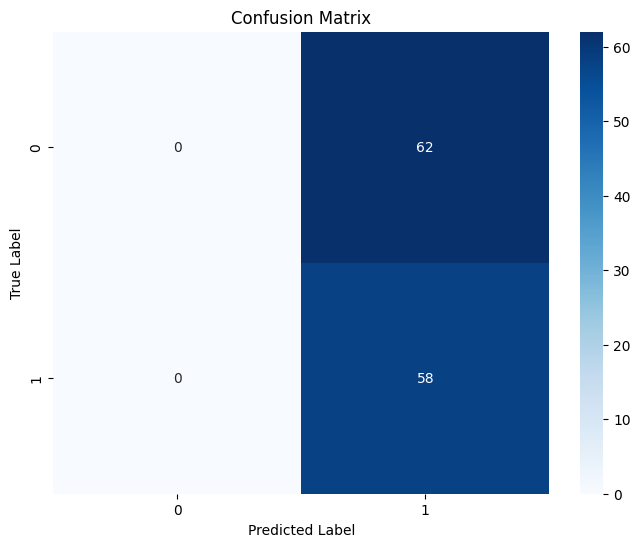

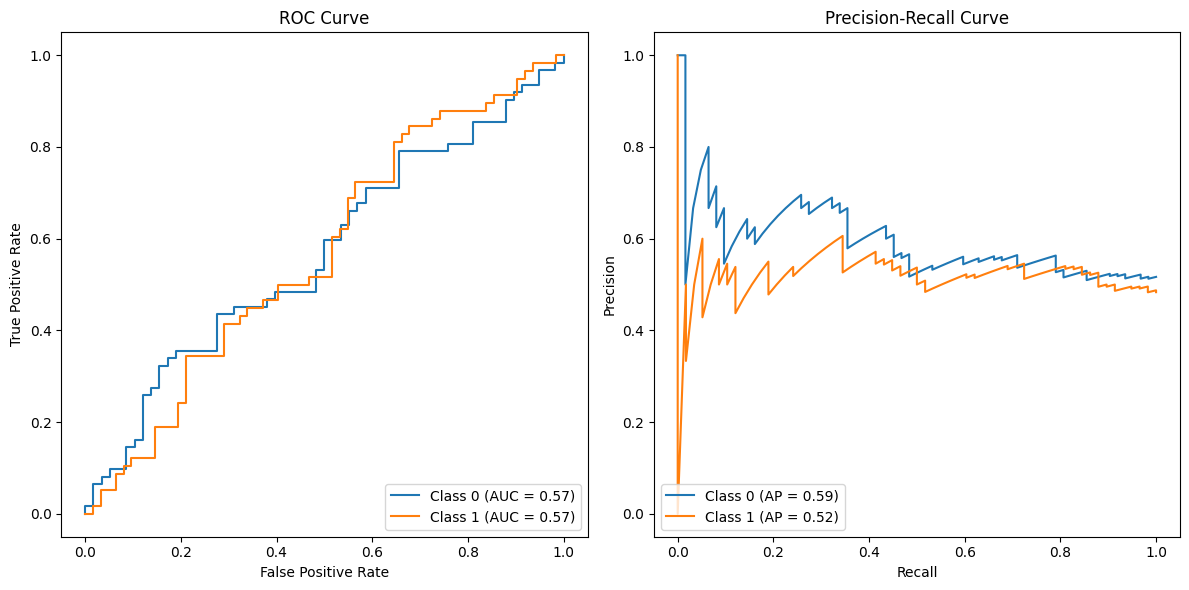

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

train_images = np.load("train_inception.npy", allow_pickle=True)  
test_images = np.load("test_inception.npy", allow_pickle=True)    
train_labels = np.load("train_labels.npy", allow_pickle=True)
test_labels = np.load("test_labels.npy", allow_pickle=True)

print(f"train_images.shape: {train_images.shape}")
print(f"train_labels.shape: {train_labels.shape}")

# One-hot encode the labels
num_classes = len(np.unique(train_labels))
train_labels_categorical = to_categorical(train_labels, num_classes)
test_labels_categorical = to_categorical(test_labels, num_classes)

assert train_images.shape[0] == train_labels_categorical.shape[0], "Mismatch in training data"
assert test_images.shape[0] == test_labels_categorical.shape[0], "Mismatch in test data"

# Load Pretrained XceptionNet model with weights from ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(train_images.shape[1], train_images.shape[1], 3))

# Freeze the base layers of XceptionNet to retain pretrained features
for layer in base_model.layers:
    layer.trainable = False

# Build the model using Xception's feature extractor and add custom classification layers
model = models.Sequential([
    layers.InputLayer(input_shape=(train_images.shape[1],)),  # 2048-dimensional feature vector
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

batch_size = 16
history = model.fit(
    train_images, train_labels_categorical,
    validation_data=(test_images, test_labels_categorical),
    epochs=100,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

test_loss, test_accuracy = model.evaluate(test_images, test_labels_categorical)
print(f"\nTest Accuracy: {test_accuracy:.2f}")

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_categorical, axis=1)

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(12, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(test_labels_categorical[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    precision_pr, recall_pr, _ = precision_recall_curve(test_labels_categorical[:, i], predictions[:, i])
    ap_score = auc(recall_pr, precision_pr)

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

    plt.subplot(1, 2, 2)
    plt.plot(recall_pr, precision_pr, label=f"Class {i} (AP = {ap_score:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

train_images.shape: (480, 2048)
train_labels.shape: (480,)
Epoch 1/100


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4972 - loss: 1.0424 - val_accuracy: 0.4833 - val_loss: 0.7059 - learning_rate: 1.0000e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5127 - loss: 0.9497 - val_accuracy: 0.4833 - val_loss: 0.7116 - learning_rate: 1.0000e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4819 - loss: 0.9057 - val_accuracy: 0.4833 - val_loss: 0.7212 - learning_rate: 1.0000e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5258 - loss: 0.9011 - val_accuracy: 0.4750 - val_loss: 0.7358 - learning_rate: 1.0000e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5631 - loss: 0.8342 - val_accuracy: 0.4417 - val_loss: 0.7461 - learning_rate: 1.0000e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5727 - loss: 0.8069 - val_accuracy: 0.4833 - val_loss: 0.7634 - learning_rate: 1.0000e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5575 - loss: 0.82

c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

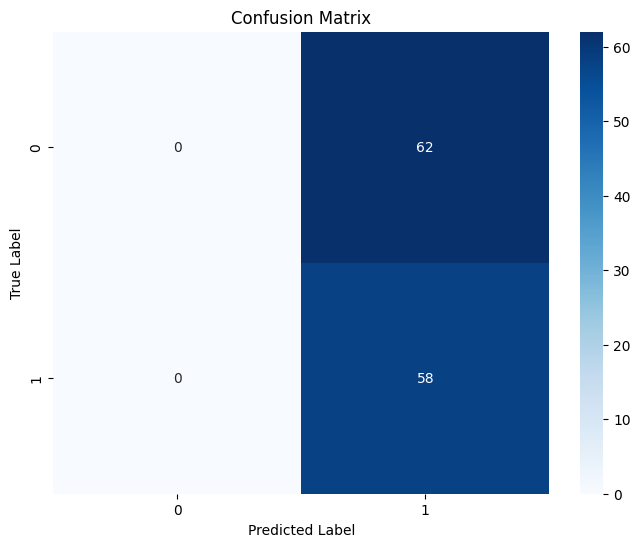

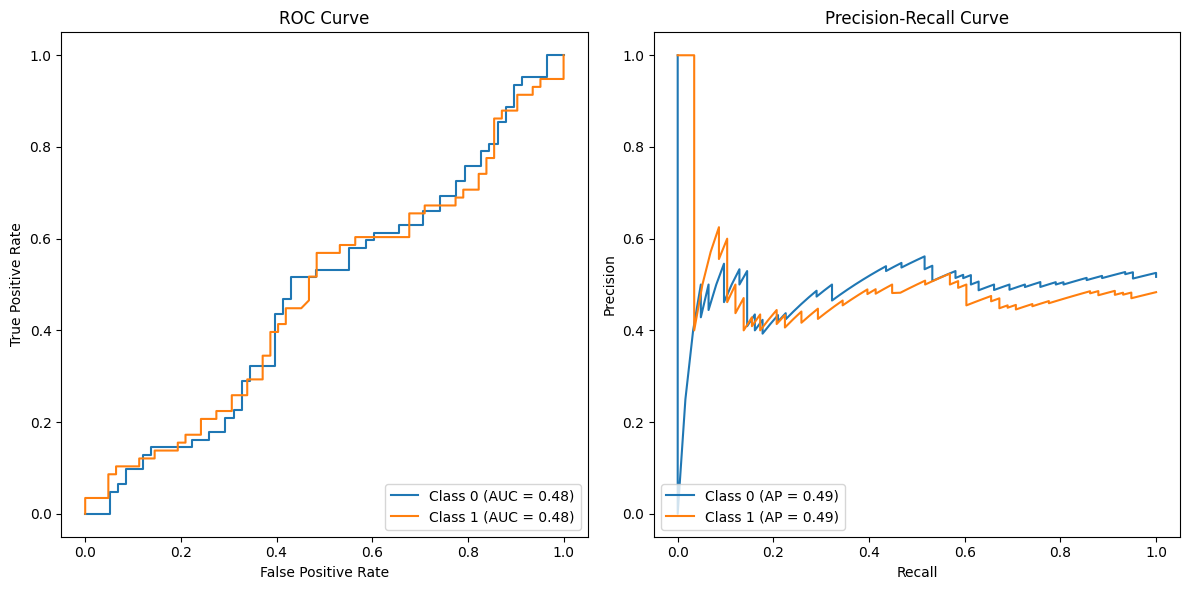

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3  

train_images = np.load("train_inception.npy", allow_pickle=True)  
test_images = np.load("test_inception.npy", allow_pickle=True)    
train_labels = np.load("train_labels.npy", allow_pickle=True)
test_labels = np.load("test_labels.npy", allow_pickle=True)

print(f"train_images.shape: {train_images.shape}")
print(f"train_labels.shape: {train_labels.shape}")

# One-hot encode the labels
num_classes = len(np.unique(train_labels))
train_labels_categorical = to_categorical(train_labels, num_classes)
test_labels_categorical = to_categorical(test_labels, num_classes)

assert train_images.shape[0] == train_labels_categorical.shape[0], "Mismatch in training data"
assert test_images.shape[0] == test_labels_categorical.shape[0], "Mismatch in test data"

# Load Pretrained GoogLeNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(train_images.shape[1], train_images.shape[1], 3))

# Freeze the base layers to retain pretrained features
for layer in base_model.layers:
    layer.trainable = False

# Build the model using GoogLeNet's feature extractor and add custom dense layers
model = models.Sequential([
    layers.InputLayer(input_shape=(train_images.shape[1],)),  # 2048-dimensional feature vector
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

batch_size = 16
history = model.fit(
    train_images, train_labels_categorical,
    validation_data=(test_images, test_labels_categorical),
    epochs=100,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

test_loss, test_accuracy = model.evaluate(test_images, test_labels_categorical)
print(f"\nTest Accuracy: {test_accuracy:.2f}")

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_categorical, axis=1)

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(12, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(test_labels_categorical[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    precision_pr, recall_pr, _ = precision_recall_curve(test_labels_categorical[:, i], predictions[:, i])
    ap_score = auc(recall_pr, precision_pr)

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

    plt.subplot(1, 2, 2)
    plt.plot(recall_pr, precision_pr, label=f"Class {i} (AP = {ap_score:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

train_images.shape: (480, 2048)
train_labels.shape: (480,)
Final train_images shape: (480, 2048)
Categorical train_labels shape: (480, 2)
Epoch 1/50


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4495 - loss: 1.1738 - val_accuracy: 0.5167 - val_loss: 0.7242 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5103 - loss: 0.8156 - val_accuracy: 0.4833 - val_loss: 0.7084 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4452 - loss: 0.7912 - val_accuracy: 0.4833 - val_loss: 0.7227 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5145 - loss: 0.7728 - val_accuracy: 0.5167 - val_loss: 0.6969 - learning_rate: 0.0010
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5096 - loss: 0.7274 - val_accuracy: 0.5167 - val_loss: 0.7294 - learning_rate: 0.0010
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4806 - loss: 0.7393 - val_accuracy: 0.5167 - val_loss: 0.6956 - learning_rate: 0.0010
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4439 - loss: 0.7292 - val_accuracy: 0.51

c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

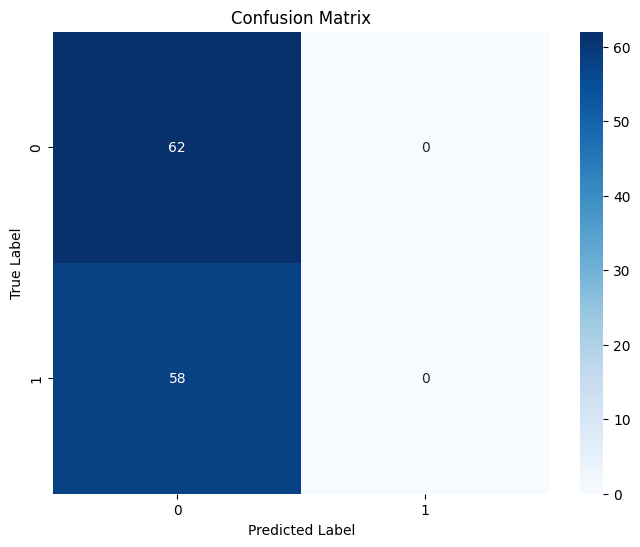

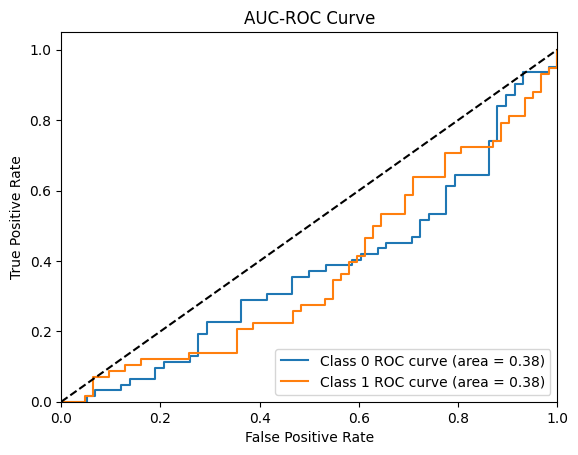

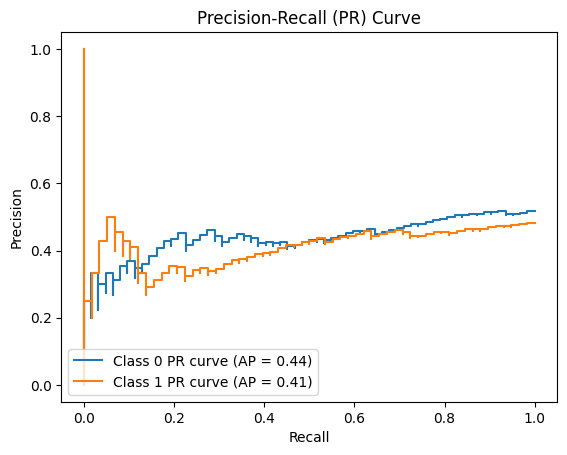

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load image and label data
train_images = np.load("train_inception.npy", allow_pickle=True)
test_images = np.load("test_inception.npy", allow_pickle=True)
train_labels = np.load("train_labels.npy", allow_pickle=True)
test_labels = np.load("test_labels.npy", allow_pickle=True)

print(f"train_images.shape: {train_images.shape}")
print(f"train_labels.shape: {train_labels.shape}")

if len(train_images.shape) == 2:
    input_shape = (train_images.shape[1],)  
else:
    image_size = (128, 128)
    train_images = train_images.reshape((-1, image_size[0], image_size[1], 3)).astype('float32') / 255.0
    test_images = test_images.reshape((-1, image_size[0], image_size[1], 3)).astype('float32') / 255.0
    input_shape = (image_size[0], image_size[1], 3)

# One-hot encode the labels
num_classes = len(np.unique(train_labels))
train_labels_categorical = to_categorical(train_labels, num_classes)
test_labels_categorical = to_categorical(test_labels, num_classes)

print(f"Final train_images shape: {train_images.shape}")
print(f"Categorical train_labels shape: {train_labels_categorical.shape}")

# Ensure matching data dimensions
assert train_images.shape[0] == train_labels_categorical.shape[0], "Mismatch in training data dimensions"
assert test_images.shape[0] == test_labels_categorical.shape[0], "Mismatch in test data dimensions"

def SqueezeNet(input_shape, num_classes):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = SqueezeNet(input_shape=input_shape, num_classes=num_classes)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

batch_size = 32
history = model.fit(
    train_images, train_labels_categorical,
    validation_data=(test_images, test_labels_categorical),
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

test_loss, test_accuracy = model.evaluate(test_images, test_labels_categorical)
print(f"\nTest Accuracy: {test_accuracy:.2f}")

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_categorical, axis=1)

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_categorical[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()

precision = {}
recall = {}
average_precision = {}

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_labels_categorical[:, i], predictions[:, i])
    average_precision[i] = average_precision_score(test_labels_categorical[:, i], predictions[:, i])

plt.figure()
for i in range(num_classes):
    plt.step(recall[i], precision[i], where='post', label=f'Class {i} PR curve (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc='lower left')
plt.show()

DATA AUGMENTATION

AUGMENTATION USING TRADITIONAL METHODS(SCALING,FLIPPING AND ROTATION)

In [ ]:
import torch
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Sample data for demonstration
feature_dim = 64
all_features = {f"sample_{i}": np.random.randn(feature_dim) for i in range(100)}

real_features = np.array(list(all_features.values()))
feature_dim = real_features.shape[1]
real_features_tensor = torch.tensor(real_features, dtype=torch.float32).to(device)

# Traditional Data Augmentation function
def augment_features(features):
    augmented = []
    for feature in features:
        feature_tensor = torch.tensor(feature, dtype=torch.float32)

        # Check if feature_dim is a perfect square for spatial operations
        feature_side = int(np.sqrt(feature_dim))
        if feature_side * feature_side != feature_dim:
            # For non-square features, apply simple augmentations (rotation, scaling)
            noisy_feature = feature_tensor + torch.randn_like(feature_tensor) 
            scaled_feature = noisy_feature * random.uniform(0.8, 1.2)  
            mask = torch.bernoulli(torch.ones_like(scaled_feature) * 0.9) 
            masked_feature = scaled_feature * mask
            augmented.append(masked_feature.numpy())
        else:
            # Spatial augmentations for square-shaped features
            feature_2d = feature_tensor.reshape(1, feature_side, feature_side)

            # Random rotation within a range (-30 to 30 degrees)
            angle = random.randint(-30, 30)
            rotated = torch.rot90(feature_2d, k=angle // 90, dims=(1, 2))

            # Random flipping
            if random.random() > 0.5:
                rotated = torch.flip(rotated, dims=[1])
            if random.random() > 0.5:
                rotated = torch.flip(rotated, dims=[2])

            # Random scaling
            scale_factor = random.uniform(0.8, 1.2)
            scaled = rotated * scale_factor

            # Add the .contiguous() call before reshaping
            augmented.append(scaled.contiguous().reshape(-1).numpy())

    return np.array(augmented)

print("Starting augmentation (flipping, rotation, and scaling)...")
augmented_features = augment_features(real_features)
print(f"Augmentation complete. Shape: {augmented_features.shape}")


np.save("augmented_features.npy", augmented_features)

all_combined_features = np.vstack([real_features, augmented_features])

def compute_stats(data):
    return {
        "mean": np.mean(data),
        "std": np.std(data),
        "min": np.min(data),
        "max": np.max(data),
        "shape": data.shape
    }

real_stats = compute_stats(real_features)
augmented_stats = compute_stats(augmented_features)
combined_stats = compute_stats(all_combined_features)

print("\n===== Dataset Statistics =====")
print(f"Original Features:  Shape={real_stats['shape']}, Mean={real_stats['mean']:.4f}, Std={real_stats['std']:.4f}")
print(f"Augmented Features: Shape={augmented_stats['shape']}, Mean={augmented_stats['mean']:.4f}, Std={augmented_stats['std']:.4f}")
print(f"Combined Features:  Shape={combined_stats['shape']}, Mean={combined_stats['mean']:.4f}, Std={combined_stats['std']:.4f}")


Using device: cuda
Starting augmentation (flipping, rotation, and scaling)...
Augmentation complete. Shape: (100, 64)

===== Dataset Statistics =====
Original Features:  Shape=(100, 64), Mean=0.0164, Std=0.9982
Augmented Features: Shape=(100, 64), Mean=0.0171, Std=1.0191
Combined Features:  Shape=(200, 64), Mean=0.0167, Std=1.0087


AUGMENTATION USING VANILLA GAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Sample data for demonstration 
feature_dim = 64
all_features = {f"sample_{i}": np.random.randn(feature_dim) for i in range(100)}

real_features = np.array(list(all_features.values()))
feature_dim = real_features.shape[1]
real_features_tensor = torch.tensor(real_features, dtype=torch.float32).to(device)

# Define Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, output_dim),
            nn.Tanh()  
        )

    def forward(self, x):
        return self.model(x)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize models
generator = Generator(input_dim=100, output_dim=feature_dim).to(device)
discriminator = Discriminator(input_dim=feature_dim).to(device)

# Define loss function and optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop for GAN
num_epochs = 500
batch_size = 32
print("\nStarting GAN training...")

for epoch in range(num_epochs):
    d_optimizer.zero_grad()

    # Real batch with smoothed labels
    real_labels = torch.ones(batch_size, 1).to(device) * 0.9
    indices = random.sample(range(len(real_features)), batch_size)
    real_batch = real_features_tensor[indices].to(device)
    real_output = discriminator(real_batch)
    real_loss = criterion(real_output, real_labels)

    # Fake batch
    noise = torch.randn(batch_size, 100).to(device)
    fake_features = generator(noise)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    fake_output = discriminator(fake_features.detach())
    fake_loss = criterion(fake_output, fake_labels)

    # Discriminator total loss
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()

    # Train Generator to fool the discriminator
    g_optimizer.zero_grad()
    noise = torch.randn(batch_size, 100).to(device)
    fake_features = generator(noise)
    fake_output = discriminator(fake_features)
    g_loss = criterion(fake_output, torch.ones(batch_size, 1).to(device))
    g_loss.backward()
    g_optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

print("GAN training complete.")

# Generate synthetic features with GAN
num_synthetic_samples = 700
print(f"\nGenerating {num_synthetic_samples} synthetic samples...")
noise = torch.randn(num_synthetic_samples, 100).to(device)
synthetic_features = generator(noise).cpu().detach().numpy()

np.save("synthetic_features.npy", synthetic_features)

all_combined_features = np.vstack([real_features, synthetic_features])

def compute_stats(data):
    return {
        "mean": np.mean(data),
        "std": np.std(data),
        "min": np.min(data),
        "max": np.max(data),
        "shape": data.shape
    }

real_stats = compute_stats(real_features)
synthetic_stats = compute_stats(synthetic_features)
combined_stats = compute_stats(all_combined_features)

print("\n===== Dataset Statistics =====")
print(f"Original Features:  Shape={real_stats['shape']}, Mean={real_stats['mean']:.4f}, Std={real_stats['std']:.4f}")
print(f"Synthetic Features: Shape={synthetic_stats['shape']}, Mean={synthetic_stats['mean']:.4f}, Std={synthetic_stats['std']:.4f}")
print(f"Combined Features:  Shape={combined_stats['shape']}, Mean={combined_stats['mean']:.4f}, Std={combined_stats['std']:.4f}")


Using device: cuda

Starting GAN training...
Epoch [50/500], D Loss: 1.2590, G Loss: 0.7100
Epoch [100/500], D Loss: 1.1803, G Loss: 0.8384
Epoch [150/500], D Loss: 1.1203, G Loss: 0.8948
Epoch [200/500], D Loss: 1.0607, G Loss: 1.0065
Epoch [250/500], D Loss: 0.9979, G Loss: 1.1939
Epoch [300/500], D Loss: 0.8676, G Loss: 1.4137
Epoch [350/500], D Loss: 0.9284, G Loss: 1.3835
Epoch [400/500], D Loss: 0.7309, G Loss: 1.5914
Epoch [450/500], D Loss: 0.7501, G Loss: 1.6371
Epoch [500/500], D Loss: 0.7995, G Loss: 1.8372
GAN training complete.

Generating 700 synthetic samples...

===== Dataset Statistics =====
Original Features:  Shape=(100, 64), Mean=-0.0158, Std=0.9993
Synthetic Features: Shape=(700, 64), Mean=-0.0172, Std=0.8444
Combined Features:  Shape=(800, 64), Mean=-0.0170, Std=0.8653


Splitting data into Training and Test set

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

inception_features = np.load("inception_features.npy", allow_pickle=True)
densenet_features = np.load("densenet_features.npy", allow_pickle=True)

if isinstance(inception_features, dict):
    inception_features = np.array(list(inception_features.values()))
if isinstance(densenet_features, dict):
    densenet_features = np.array(list(densenet_features.values()))

print(f"Inception Features Shape: {inception_features.shape}")
print(f"DenseNet Features Shape: {densenet_features.shape}")

if inception_features.shape[0] != densenet_features.shape[0]:
    raise ValueError(f"Mismatch in dataset size! Inception: {inception_features.shape[0]}, DenseNet: {densenet_features.shape[0]}")

num_samples = inception_features.shape[0]
labels = np.random.randint(0, 2, num_samples) 

assert len(labels) == num_samples, "Number of labels must match the number of samples"

# Stratified split if possible to maintain class balance
train_indices, test_indices = train_test_split(
    np.arange(num_samples), test_size=0.2, random_state=42, stratify=labels
)

train_inception = inception_features[train_indices]
test_inception = inception_features[test_indices]
train_densenet = densenet_features[train_indices]
test_densenet = densenet_features[test_indices]
train_labels = labels[train_indices]
test_labels = labels[test_indices]

np.save("train_inception.npy", train_inception)
np.save("test_inception.npy", test_inception)
np.save("train_densenet.npy", train_densenet)
np.save("test_densenet.npy", test_densenet)
np.save("train_labels.npy", train_labels)
np.save("test_labels.npy", test_labels)

print("\nDataset successfully split into training (80%) and test (20%) sets.")
print(f"Train set size: {train_inception.shape[0]}, Test set size: {test_inception.shape[0]}")
print(f"Train Labels: {np.unique(train_labels, return_counts=True)}")
print(f"Test Labels: {np.unique(test_labels, return_counts=True)}")

Inception Features Shape: (600, 2048)
DenseNet Features Shape: (600, 1024)

Dataset successfully split into training (80%) and test (20%) sets.
Train set size: 480, Test set size: 120
Train Labels: (array([0, 1]), array([254, 226], dtype=int64))
Test Labels: (array([0, 1]), array([64, 56], dtype=int64))


MODEL TRAINING 

train_images.shape: (480, 2048)
train_labels.shape: (480,)
Final train_images shape: (480, 2048)
Categorical train_labels shape: (480, 2)
Epoch 1/50


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5349 - loss: 0.9787 - val_accuracy: 0.4667 - val_loss: 0.9104 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4873 - loss: 0.9662 - val_accuracy: 0.4667 - val_loss: 0.7108 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4938 - loss: 0.7752 - val_accuracy: 0.4667 - val_loss: 0.7096 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5131 - loss: 0.7350 - val_accuracy: 0.4667 - val_loss: 0.7067 - learning_rate: 0.0010
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4990 - loss: 0.7233 - val_accuracy: 0.4333 - val_loss: 0.6964 - learning_rate: 0.0010
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5258 - loss: 0.6983 - val_accuracy: 0.4667 - val_loss: 0.6992 - learning_rate: 0.0010
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4753 - loss: 0.7209 - val_accuracy: 0.533

c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

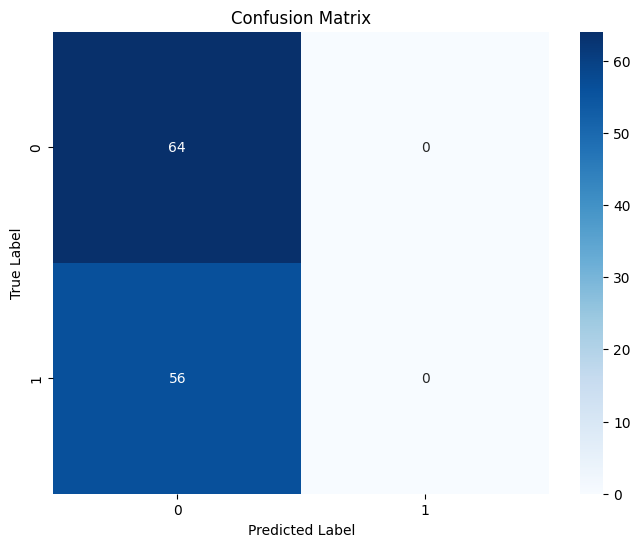

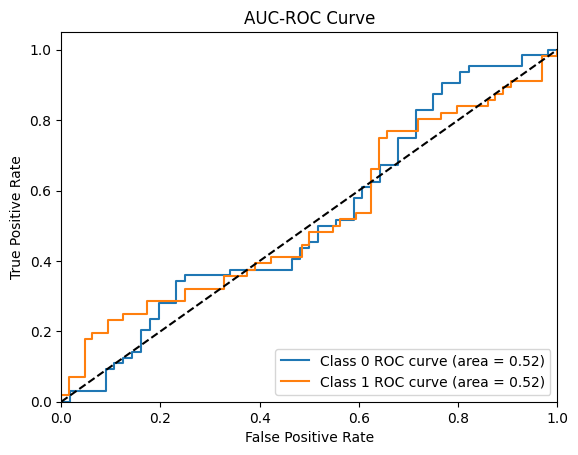

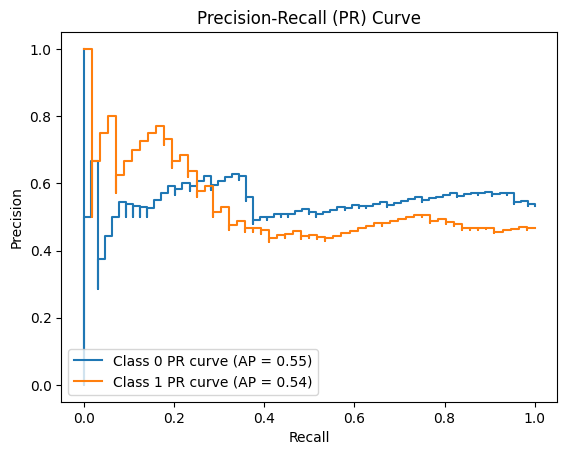

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

train_images = np.load("train_inception.npy", allow_pickle=True)
test_images = np.load("test_inception.npy", allow_pickle=True)
train_labels = np.load("train_labels.npy", allow_pickle=True)
test_labels = np.load("test_labels.npy", allow_pickle=True)

print(f"train_images.shape: {train_images.shape}")
print(f"train_labels.shape: {train_labels.shape}")

# If train_images has been flattened (480, 2048), skip reshaping to 3D and retain the shape
if len(train_images.shape) == 2:
    input_shape = (train_images.shape[1],)  # Shape: (2048,) if already flattened
else:
    image_size = (128, 128)
    train_images = train_images.reshape((-1, image_size[0], image_size[1], 3)).astype('float32') / 255.0
    test_images = test_images.reshape((-1, image_size[0], image_size[1], 3)).astype('float32') / 255.0
    input_shape = (image_size[0], image_size[1], 3)

# One-hot encode the labels
num_classes = len(np.unique(train_labels))
train_labels_categorical = to_categorical(train_labels, num_classes)
test_labels_categorical = to_categorical(test_labels, num_classes)

print(f"Final train_images shape: {train_images.shape}")
print(f"Categorical train_labels shape: {train_labels_categorical.shape}")

# Ensure matching data dimensions
assert train_images.shape[0] == train_labels_categorical.shape[0], "Mismatch in training data dimensions"
assert test_images.shape[0] == test_labels_categorical.shape[0], "Mismatch in test data dimensions"

def SqueezeNet(input_shape, num_classes):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = SqueezeNet(input_shape=input_shape, num_classes=num_classes)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

batch_size = 32
history = model.fit(
    train_images, train_labels_categorical,
    validation_data=(test_images, test_labels_categorical),
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

test_loss, test_accuracy = model.evaluate(test_images, test_labels_categorical)
print(f"\nTest Accuracy: {test_accuracy:.2f}")

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_categorical, axis=1)

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_categorical[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()

precision = {}
recall = {}
average_precision = {}

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_labels_categorical[:, i], predictions[:, i])
    average_precision[i] = average_precision_score(test_labels_categorical[:, i], predictions[:, i])

plt.figure()
for i in range(num_classes):
    plt.step(recall[i], precision[i], where='post', label=f'Class {i} PR curve (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc='lower left')
plt.show()

train_images.shape: (480, 2048)
train_labels.shape: (480,)
Epoch 1/100


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5118 - loss: 1.0697 - val_accuracy: 0.5333 - val_loss: 0.6928 - learning_rate: 1.0000e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5337 - loss: 1.0100 - val_accuracy: 0.5250 - val_loss: 0.6941 - learning_rate: 1.0000e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5652 - loss: 0.8746 - val_accuracy: 0.5167 - val_loss: 0.7043 - learning_rate: 1.0000e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5053 - loss: 1.0022 - val_accuracy: 0.5333 - val_loss: 0.7211 - learning_rate: 1.0000e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5447 - loss: 0.8679 - val_accuracy: 0.5333 - val_loss: 0.7356 - learning_rate: 1.0000e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5484 - loss: 0.8743 - val_accuracy: 0.4750 - val_loss: 0.7215 - learning_rate: 1.0000e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5357 - loss: 0.94

c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

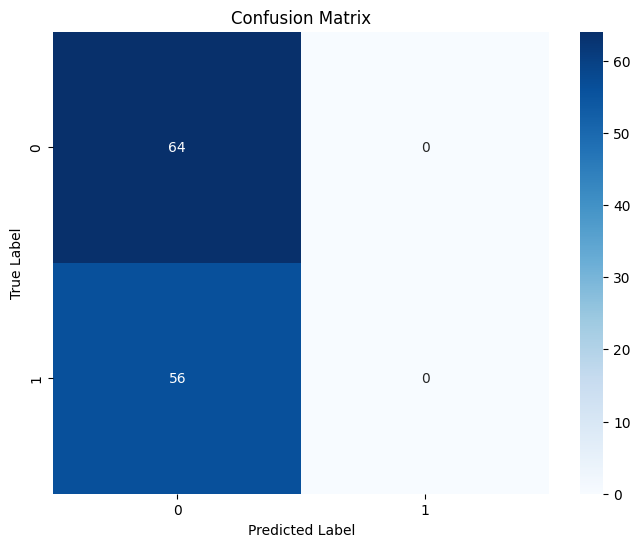

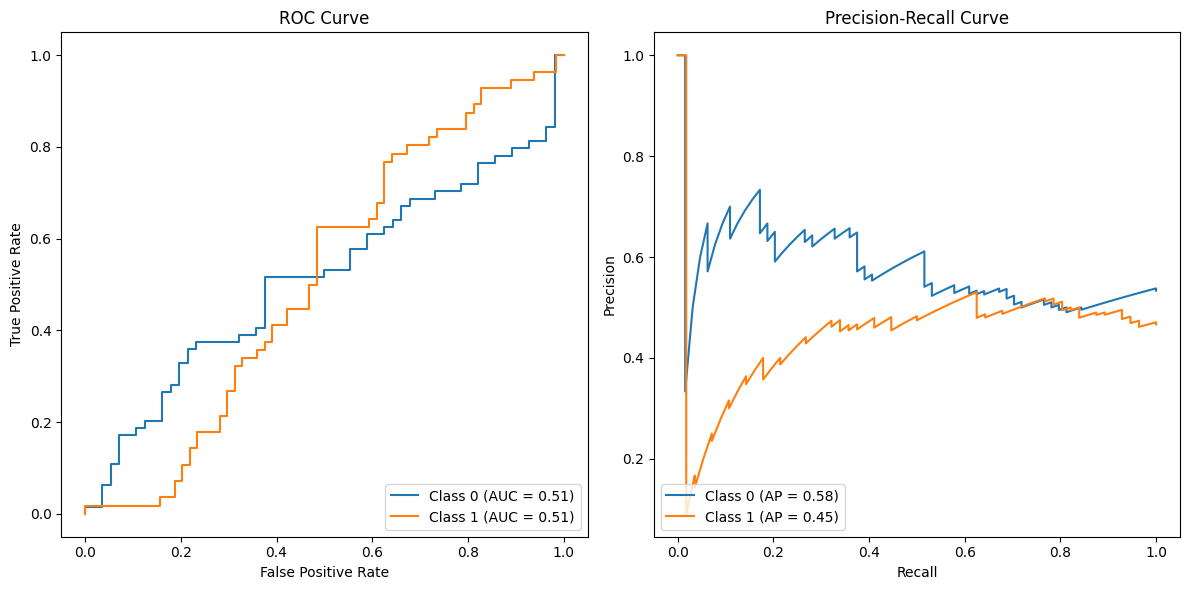

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3  

train_images = np.load("train_inception.npy", allow_pickle=True)  
test_images = np.load("test_inception.npy", allow_pickle=True)    
train_labels = np.load("train_labels.npy", allow_pickle=True)
test_labels = np.load("test_labels.npy", allow_pickle=True)

print(f"train_images.shape: {train_images.shape}")
print(f"train_labels.shape: {train_labels.shape}")

# One-hot encode the labels
num_classes = len(np.unique(train_labels))
train_labels_categorical = to_categorical(train_labels, num_classes)
test_labels_categorical = to_categorical(test_labels, num_classes)

assert train_images.shape[0] == train_labels_categorical.shape[0], "Mismatch in training data"
assert test_images.shape[0] == test_labels_categorical.shape[0], "Mismatch in test data"

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(train_images.shape[1], train_images.shape[1], 3))

# Freeze the base layers to retain pretrained features
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    layers.InputLayer(input_shape=(train_images.shape[1],)),  
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Add callbacks to prevent overfitting and improve training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

batch_size = 16
history = model.fit(
    train_images, train_labels_categorical,
    validation_data=(test_images, test_labels_categorical),
    epochs=100,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

test_loss, test_accuracy = model.evaluate(test_images, test_labels_categorical)
print(f"\nTest Accuracy: {test_accuracy:.2f}")

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_categorical, axis=1)

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(12, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(test_labels_categorical[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    precision_pr, recall_pr, _ = precision_recall_curve(test_labels_categorical[:, i], predictions[:, i])
    ap_score = auc(recall_pr, precision_pr)

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

    plt.subplot(1, 2, 2)
    plt.plot(recall_pr, precision_pr, label=f"Class {i} (AP = {ap_score:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


train_images.shape: (480, 2048)
train_labels.shape: (480,)
Epoch 1/100


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4949 - loss: 1.0726 - val_accuracy: 0.5333 - val_loss: 0.7097 - learning_rate: 1.0000e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5329 - loss: 0.9037 - val_accuracy: 0.5333 - val_loss: 0.7042 - learning_rate: 1.0000e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5382 - loss: 0.8923 - val_accuracy: 0.5583 - val_loss: 0.6912 - learning_rate: 1.0000e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5931 - loss: 0.8401 - val_accuracy: 0.5167 - val_loss: 0.6916 - learning_rate: 1.0000e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5532 - loss: 0.9441 - val_accuracy: 0.5000 - val_loss: 0.6971 - learning_rate: 1.0000e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5521 - loss: 0.9124 - val_accuracy: 0.5167 - val_loss: 0.7024 - learning_rate: 1.0000e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5401 - loss: 0.90

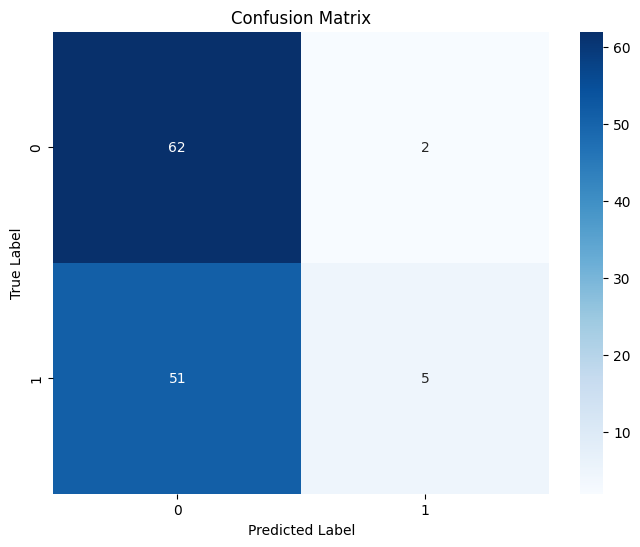

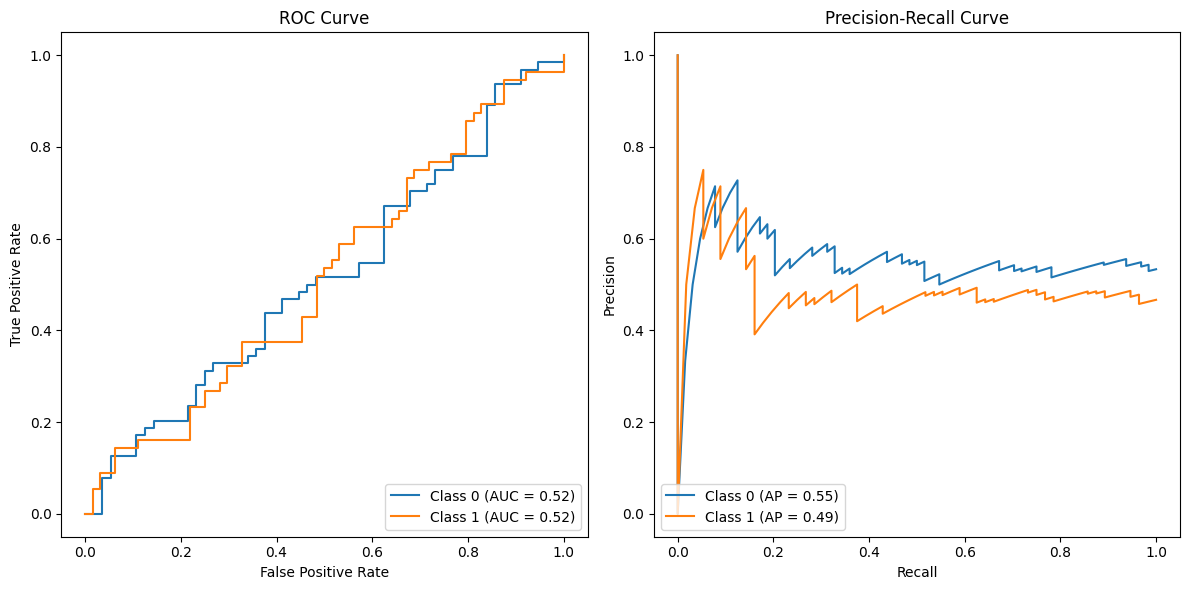

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

train_images = np.load("train_inception.npy", allow_pickle=True)  
test_images = np.load("test_inception.npy", allow_pickle=True)    
train_labels = np.load("train_labels.npy", allow_pickle=True)
test_labels = np.load("test_labels.npy", allow_pickle=True)


print(f"train_images.shape: {train_images.shape}")
print(f"train_labels.shape: {train_labels.shape}")


num_classes = len(np.unique(train_labels))
train_labels_categorical = to_categorical(train_labels, num_classes)
test_labels_categorical = to_categorical(test_labels, num_classes)

assert train_images.shape[0] == train_labels_categorical.shape[0], "Mismatch in training data"
assert test_images.shape[0] == test_labels_categorical.shape[0], "Mismatch in test data"

# Load Pretrained XceptionNet model with weights from ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(train_images.shape[1], train_images.shape[1], 3))

# Freeze the base layers of XceptionNet to retain pretrained features
for layer in base_model.layers:
    layer.trainable = False

# Build the model using Xception's feature extractor and add custom classification layers
model = models.Sequential([
    layers.InputLayer(input_shape=(train_images.shape[1],)), 
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Add callbacks to prevent overfitting and optimize learning
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

batch_size = 16
history = model.fit(
    train_images, train_labels_categorical,
    validation_data=(test_images, test_labels_categorical),
    epochs=100,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

test_loss, test_accuracy = model.evaluate(test_images, test_labels_categorical)
print(f"\nTest Accuracy: {test_accuracy:.2f}")

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_categorical, axis=1)

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(12, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(test_labels_categorical[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    precision_pr, recall_pr, _ = precision_recall_curve(test_labels_categorical[:, i], predictions[:, i])
    ap_score = auc(recall_pr, precision_pr)

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

    plt.subplot(1, 2, 2)
    plt.plot(recall_pr, precision_pr, label=f"Class {i} (AP = {ap_score:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

train_images.shape: (480, 2048)
train_labels.shape: (480,)
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.4457 - loss: 1.0630 - val_accuracy: 0.5333 - val_loss: 0.6913 - learning_rate: 1.0000e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5291 - loss: 0.8983 - val_accuracy: 0.4417 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5439 - loss: 0.8877 - val_accuracy: 0.4667 - val_loss: 0.6966 - learning_rate: 1.0000e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5033 - loss: 0.9584 - val_accuracy: 0.4667 - val_loss: 0.6961 - learning_rate: 1.0000e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5744 - loss: 0.8910 - val_accuracy: 0.4667 - val_loss: 0.7047 - learning_rate: 1.0000e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5782 - loss: 0.7912 - val_accuracy: 0.4667 - val_loss: 0.7319 - learning_rate: 1.0000e-04
Epoch

c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

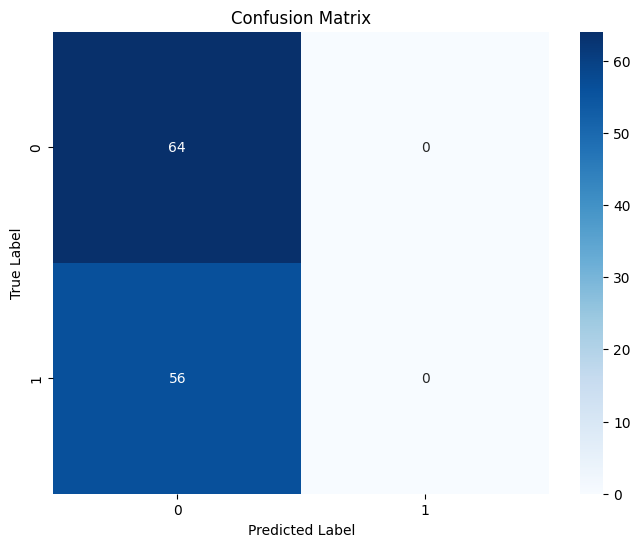

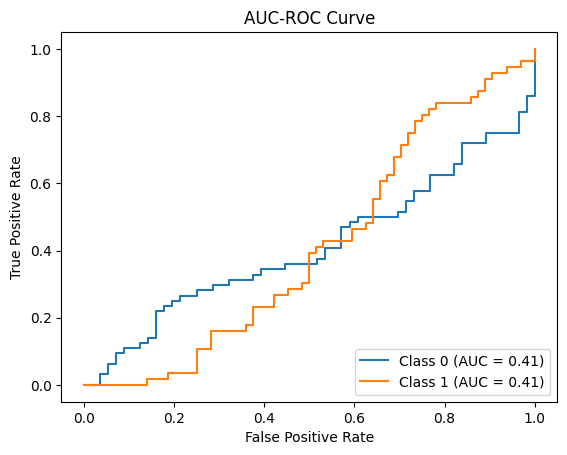

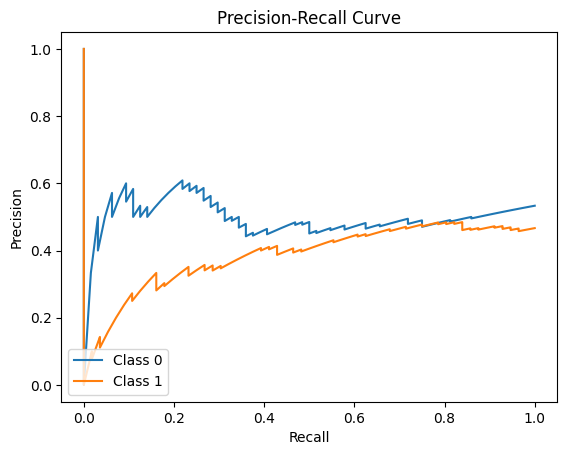

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

train_images = np.load("train_inception.npy", allow_pickle=True)  
test_images = np.load("test_inception.npy", allow_pickle=True)    
train_labels = np.load("train_labels.npy", allow_pickle=True)
test_labels = np.load("test_labels.npy", allow_pickle=True)

print(f"train_images.shape: {train_images.shape}")
print(f"train_labels.shape: {train_labels.shape}")

num_classes = len(np.unique(train_labels))
train_labels_categorical = to_categorical(train_labels, num_classes)
test_labels_categorical = to_categorical(test_labels, num_classes)

assert train_images.shape[0] == train_labels_categorical.shape[0], "Mismatch in training data"
assert test_images.shape[0] == test_labels_categorical.shape[0], "Mismatch in test data"

train_images = np.reshape(train_images, (train_images.shape[0], 32, 64, 1))  
test_images = np.reshape(test_images, (test_images.shape[0], 32, 64, 1))
input_shape = (32, 64, 1)

def coatnet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Initial Convolutional Stem Layer (Feature Extraction)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # CoAtNet-Like Blocks with Convolutions and Attention Mechanisms
    for _ in range(2):  # Block 1: Convolutional focus
        x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)  # Block 2: Attention
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)  # Block 3: Hybrid
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Build the CoAtNet model with fixed input shape
model = coatnet_model(input_shape=input_shape, num_classes=num_classes)

# Callbacks to prevent overfitting and improve training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

batch_size = 16
history = model.fit(
    train_images, train_labels_categorical,
    validation_data=(test_images, test_labels_categorical),
    epochs=100,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

test_loss, test_accuracy = model.evaluate(test_images, test_labels_categorical)
print(f"\nTest Accuracy: {test_accuracy:.2f}")

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_categorical, axis=1)

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

plt.figure()
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(test_labels_categorical[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend(loc="lower right")
plt.show()

plt.figure()
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(test_labels_categorical[:, i], predictions[:, i])
    plt.plot(recall, precision, label=f"Class {i}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

APPLYING METAHEURISTIC ALGORITHMS 

In [5]:
!pip install deap

Defaulting to user installation because normal site-packages is not writeable


In [2]:
pip install deap scikit-learn keras numpy tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


APPLYING GENETIC ALGORITHM 


Starting Genetic Algorithm Optimization...



c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9550, F1: 0.9552, AUC: 0.9917, PR_AUC: 0.6511


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9650, F1: 0.9651, AUC: 0.9909, PR_AUC: 0.6509


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9450, F1: 0.9455, AUC: 0.9885, PR_AUC: 0.6442


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9400, F1: 0.9402, AUC: 0.9892, PR_AUC: 0.6478


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9600, F1: 0.9601, AUC: 0.9907, PR_AUC: 0.6495


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9550, F1: 0.9554, AUC: 0.9916, PR_AUC: 0.6512
gen	nevals
0  	6     


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9700, F1: 0.9702, AUC: 0.9901, PR_AUC: 0.6480


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9550, F1: 0.9552, AUC: 0.9876, PR_AUC: 0.6411


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9600, F1: 0.9601, AUC: 0.9905, PR_AUC: 0.6478


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Acc: 0.9350, F1: 0.9353, AUC: 0.9896, PR_AUC: 0.6457
1  	4     


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9600, F1: 0.9602, AUC: 0.9891, PR_AUC: 0.6430


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9550, F1: 0.9551, AUC: 0.9904, PR_AUC: 0.6512


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9700, F1: 0.9700, AUC: 0.9923, PR_AUC: 0.6501


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9550, F1: 0.9552, AUC: 0.9922, PR_AUC: 0.6496


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9600, F1: 0.9602, AUC: 0.9931, PR_AUC: 0.6518


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9700, F1: 0.9701, AUC: 0.9928, PR_AUC: 0.6525
2  	6     


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9600, F1: 0.9601, AUC: 0.9925, PR_AUC: 0.6502


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9600, F1: 0.9601, AUC: 0.9927, PR_AUC: 0.6539


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9500, F1: 0.9502, AUC: 0.9920, PR_AUC: 0.6522


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9550, F1: 0.9552, AUC: 0.9914, PR_AUC: 0.6487


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9550, F1: 0.9551, AUC: 0.9907, PR_AUC: 0.6455
3  	5     


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9450, F1: 0.9452, AUC: 0.9924, PR_AUC: 0.6507


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9550, F1: 0.9551, AUC: 0.9898, PR_AUC: 0.6480
4  	2     


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9600, F1: 0.9602, AUC: 0.9888, PR_AUC: 0.6452


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9400, F1: 0.9410, AUC: 0.9913, PR_AUC: 0.6494


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9600, F1: 0.9601, AUC: 0.9912, PR_AUC: 0.6504
5  	3     

Best Parameters Found: [87.59903926816177, 245, 0.16855367377333708, 26.753426373946944, 64]


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


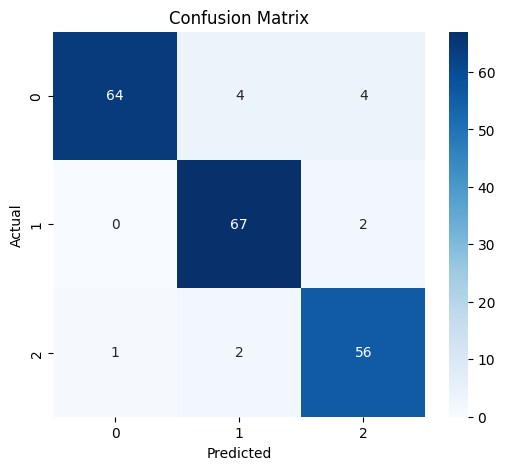

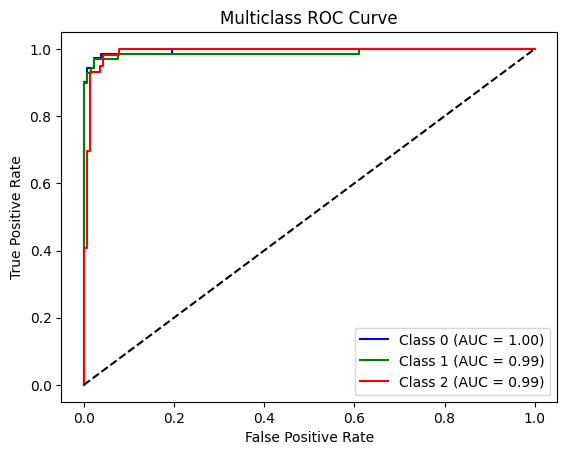

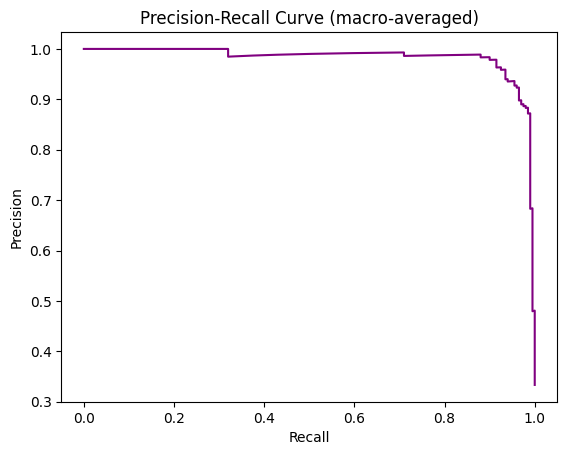

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, precision_recall_curve, 
                             confusion_matrix, roc_curve, auc)
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification
from deap import base, creator, tools, algorithms
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Create structured synthetic dataset
X, y = make_classification(
    n_samples=1000, n_features=100, n_informative=20, n_redundant=10, 
    n_classes=3, n_clusters_per_class=1, flip_y=0.03, random_state=42
)

# Train/test split and label binarization
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
y_train_cat = to_categorical(y_train)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# DEAP components
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_int", lambda: np.random.randint(32, 256))
toolbox.register("attr_dropout", lambda: np.random.uniform(0.1, 0.5))
toolbox.register("attr_epochs", lambda: np.random.randint(5, 30))
toolbox.register("attr_batch", lambda: np.random.choice([16, 32, 64]))

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_int, toolbox.attr_int, toolbox.attr_dropout, 
                  toolbox.attr_epochs, toolbox.attr_batch), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Evaluation function
def eval_model(ind):
    n1, n2 = int(ind[0]), int(ind[1])
    drop, epochs, batch = float(ind[2]), int(ind[3]), int(ind[4])

    model = Sequential()
    model.add(Dense(n1, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(n2, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train_cat, epochs=epochs, batch_size=batch, verbose=0)

    preds = np.argmax(model.predict(X_test), axis=1)
    probs = model.predict(X_test)

    precision = precision_score(y_test, preds, average='weighted')
    recall = recall_score(y_test, preds, average='weighted')
    f1 = f1_score(y_test, preds, average='weighted')
    accuracy = accuracy_score(y_test, preds)

    try:
        auc_score = roc_auc_score(y_test_bin, probs, multi_class='ovr')
    except ValueError:
        auc_score = 0.0

    try:
        precision_pr, recall_pr, _ = precision_recall_curve(y_test_bin.ravel(), probs.ravel())
        pr_auc = np.trapz(recall_pr, precision_pr)
    except:
        pr_auc = 0.0

    print(f"Acc: {accuracy:.4f}, F1: {f1:.4f}, AUC: {auc_score:.4f}, PR_AUC: {pr_auc:.4f}")
    return (accuracy + f1 + auc_score + pr_auc) / 4,

toolbox.register("evaluate", eval_model)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutPolynomialBounded, 
                 low=[32, 32, 0.1, 5, 16],
                 up=[256, 256, 0.5, 30, 64],
                 eta=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run GA
pop = toolbox.population(n=6)
hof = tools.HallOfFame(1)
N_GEN, CX_PB, MUT_PB = 5, 0.5, 0.2

print("\nStarting Genetic Algorithm Optimization...\n")
algorithms.eaSimple(pop, toolbox, cxpb=CX_PB, mutpb=MUT_PB, ngen=N_GEN, halloffame=hof, verbose=True)

# Best individual
best_ind = hof[0]
print(f"\nBest Parameters Found: {best_ind}")

# Train final model with best parameters
n1, n2 = int(best_ind[0]), int(best_ind[1])
drop, epochs, batch = float(best_ind[2]), int(best_ind[3]), int(best_ind[4])

final_model = Sequential()
final_model.add(Dense(n1, input_shape=(X_train.shape[1],), activation='relu'))
final_model.add(Dropout(drop))
final_model.add(Dense(n2, activation='relu'))
final_model.add(Dense(3, activation='softmax'))

final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
final_model.fit(X_train, y_train_cat, epochs=epochs, batch_size=batch, verbose=0)

final_preds = np.argmax(final_model.predict(X_test), axis=1)
final_probs = final_model.predict(X_test)

cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], final_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'green', 'red']
for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

precision_macro, recall_macro, _ = precision_recall_curve(y_test_bin.ravel(), final_probs.ravel())
plt.figure()
plt.plot(recall_macro, precision_macro, color='purple')
plt.title('Precision-Recall Curve (macro-averaged)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


APPLYING PARTICLE SWARM OPTIMIZATION ALGORITHM 

In [18]:
pip install pyswarm

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4484 sha256=244bcb1555e075dedc869b185dfeb3d09c34e656793f89a8384a79b2c327adcf
  Stored in directory: c:\users\muj\appdata\local\pip\cache\wheels\71\67\40\62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9500, F1: 0.9503, AUC: 0.9884, PR_AUC: 0.6421


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9500, F1: 0.9502, AUC: 0.9900, PR_AUC: 0.6474


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9600, F1: 0.9604, AUC: 0.9918, PR_AUC: 0.6502


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9500, F1: 0.9504, AUC: 0.9920, PR_AUC: 0.6496


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9150, F1: 0.9163, AUC: 0.9794, PR_AUC: 0.6198


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9550, F1: 0.9552, AUC: 0.9889, PR_AUC: 0.6430


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9600, F1: 0.9605, AUC: 0.9908, PR_AUC: 0.6479


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9550, F1: 0.9551, AUC: 0.9902, PR_AUC: 0.6464


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9550, F1: 0.9553, AUC: 0.9899, PR_AUC: 0.6475


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9350, F1: 0.9352, AUC: 0.9863, PR_AUC: 0.6429


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.7900, F1: 0.7903, AUC: 0.9363, PR_AUC: 0.5566


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9650, F1: 0.9650, AUC: 0.9932, PR_AUC: 0.6551


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9600, F1: 0.9603, AUC: 0.9913, PR_AUC: 0.6490


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9500, F1: 0.9505, AUC: 0.9906, PR_AUC: 0.6492


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9500, F1: 0.9500, AUC: 0.9917, PR_AUC: 0.6516


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9350, F1: 0.9357, AUC: 0.9920, PR_AUC: 0.6524


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.8950, F1: 0.8952, AUC: 0.9774, PR_AUC: 0.6259


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9500, F1: 0.9502, AUC: 0.9912, PR_AUC: 0.6509


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9600, F1: 0.9601, AUC: 0.9912, PR_AUC: 0.6470


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9600, F1: 0.9601, AUC: 0.9902, PR_AUC: 0.6441


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9450, F1: 0.9454, AUC: 0.9919, PR_AUC: 0.6512


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9400, F1: 0.9406, AUC: 0.9893, PR_AUC: 0.6468


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9450, F1: 0.9450, AUC: 0.9889, PR_AUC: 0.6448


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9600, F1: 0.9600, AUC: 0.9938, PR_AUC: 0.6556


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9550, F1: 0.9555, AUC: 0.9890, PR_AUC: 0.6413


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9700, F1: 0.9701, AUC: 0.9916, PR_AUC: 0.6515


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9600, F1: 0.9602, AUC: 0.9919, PR_AUC: 0.6508


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9500, F1: 0.9501, AUC: 0.9907, PR_AUC: 0.6484


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9450, F1: 0.9454, AUC: 0.9925, PR_AUC: 0.6534


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9600, F1: 0.9601, AUC: 0.9903, PR_AUC: 0.6458


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9700, F1: 0.9702, AUC: 0.9913, PR_AUC: 0.6500


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Acc: 0.9550, F1: 0.9554, AUC: 0.9901, PR_AUC: 0.6462


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9500, F1: 0.9503, AUC: 0.9901, PR_AUC: 0.6472


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
Acc: 0.9600, F1: 0.9601, AUC: 0.9926, PR_AUC: 0.6529


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9550, F1: 0.9552, AUC: 0.9905, PR_AUC: 0.6460


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acc: 0.9550, F1: 0.9552, AUC: 0.9909, PR_AUC: 0.6492
Stopping search: maximum iterations reached --> 5

Best Parameters Found: [256.         179.63642911   0.2640613   16.86595793  64.        ]
Best Score (higher better): 0.895822455399254


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


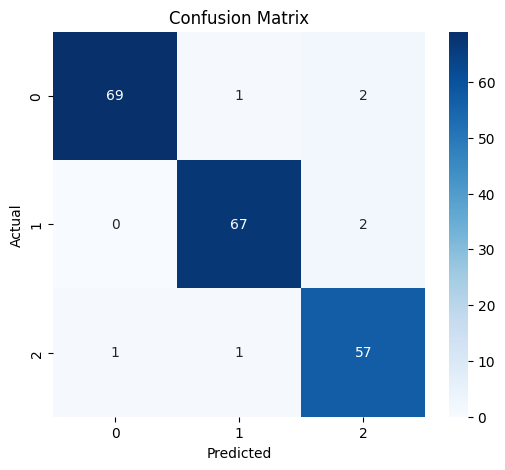

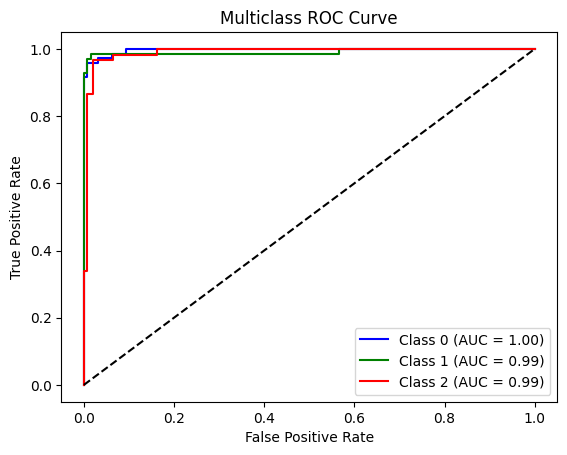

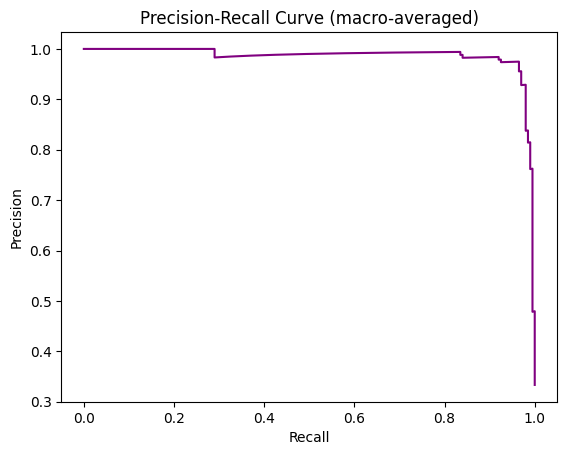

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, precision_recall_curve, 
                             confusion_matrix, roc_curve, auc)
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from pyswarm import pso

# Create structured synthetic dataset
X, y = make_classification(
    n_samples=1000, n_features=100, n_informative=20, n_redundant=10,
    n_classes=3, n_clusters_per_class=1, flip_y=0.03, random_state=42
)

# Train/test split and label binarization
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
y_train_cat = to_categorical(y_train)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Define evaluation function for PSO (minimization)
def eval_pso(params):
    n1, n2, drop, epochs, batch = params
    n1, n2, epochs, batch = int(n1), int(n2), int(epochs), int(batch)

    model = Sequential()
    model.add(Dense(n1, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(n2, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train_cat, epochs=epochs, batch_size=batch, verbose=0)

    preds = np.argmax(model.predict(X_test), axis=1)
    probs = model.predict(X_test)

    precision = precision_score(y_test, preds, average='weighted')
    recall = recall_score(y_test, preds, average='weighted')
    f1 = f1_score(y_test, preds, average='weighted')
    accuracy = accuracy_score(y_test, preds)

    try:
        auc_score = roc_auc_score(y_test_bin, probs, multi_class='ovr')
    except ValueError:
        auc_score = 0.0

    try:
        precision_pr, recall_pr, _ = precision_recall_curve(y_test_bin.ravel(), probs.ravel())
        pr_auc = np.trapz(recall_pr, precision_pr)
    except:
        pr_auc = 0.0

    # Combined score (negated because PSO minimizes)
    combined_score = (accuracy + f1 + auc_score + pr_auc) / 4
    print(f"Acc: {accuracy:.4f}, F1: {f1:.4f}, AUC: {auc_score:.4f}, PR_AUC: {pr_auc:.4f}")
    return -combined_score  # PSO minimizes — so negate

# Bounds for parameters: [neurons1, neurons2, dropout, epochs, batch_size]
lb = [32, 32, 0.1, 5, 16]
ub = [256, 256, 0.5, 30, 64]

# Run PSO
best_params, best_score = pso(eval_pso, lb, ub, swarmsize=6, maxiter=5)
print(f"\nBest Parameters Found: {best_params}")
print(f"Best Score (higher better): {-best_score}")

# Train final model with best params
n1, n2, drop, epochs, batch = best_params
n1, n2, epochs, batch = int(n1), int(n2), int(epochs), int(batch)

final_model = Sequential()
final_model.add(Dense(n1, input_shape=(X_train.shape[1],), activation='relu'))
final_model.add(Dropout(drop))
final_model.add(Dense(n2, activation='relu'))
final_model.add(Dense(3, activation='softmax'))

final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
final_model.fit(X_train, y_train_cat, epochs=epochs, batch_size=batch, verbose=0)

final_preds = np.argmax(final_model.predict(X_test), axis=1)
final_probs = final_model.predict(X_test)

cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], final_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'green', 'red']
for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

precision_macro, recall_macro, _ = precision_recall_curve(y_test_bin.ravel(), final_probs.ravel())
plt.figure()
plt.plot(recall_macro, precision_macro, color='purple')
plt.title('Precision-Recall Curve (macro-averaged)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
APPLYING GREY WOLF OPTIMIZATION

In [24]:
pip install mealpy tensorflow scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025/04/16 11:40:08 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: Solving single objective optimization problem.
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


2025/04/16 11:40:25 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: -0.8942302792406269, Global best: -0.8942302792406269, Runtime: 8.59807 seconds
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025/04/16 11:40:33 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: -0.8942302792406269, Global best: -0.8942302792406269, Runtime: 7.64105 seconds
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025/04/16 11:40:42 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: -0.8966120507895151, Global best: -0.8966120507895151, Runtime: 9.21916 seconds
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025/04/16 11:40:52 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: -0.8966120507895151, Global best: -0.8966120507895151, Runtime: 9.60224 seconds
c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025/04/16 11:41:01 AM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: -0.8974406318170749, Global best: -0.8974406318170749, Runtime: 9.08966 seconds



Best Parameters Found: [188.9221793  189.18476056   0.23218941  25.76849519  38.99898669]
Epoch 1/25


c:\Users\muj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5354 - loss: 1.1019  
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8604 - loss: 0.3760 
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9212 - loss: 0.2399 
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9251 - loss: 0.2337 
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9476 - loss: 0.1670 
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9701 - loss: 0.1173 
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9777 - loss: 0.0980 
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9690 - loss: 0.0836 
Epoch 9/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9750 - loss: 0.0812 
Epoch 10/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9785 - loss: 0.0694 
Epoch 11/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9777 - loss: 0.0720 
Epoch 12/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9937 - l

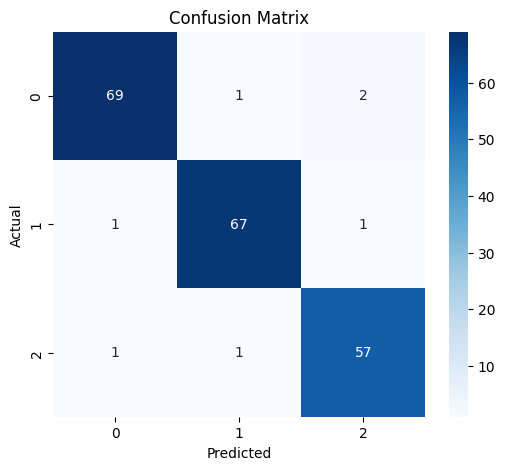

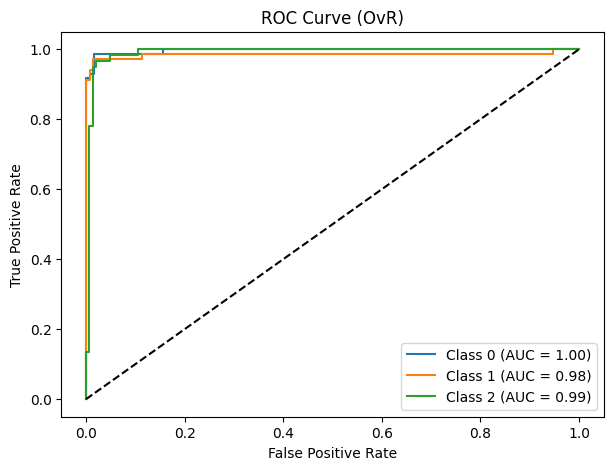

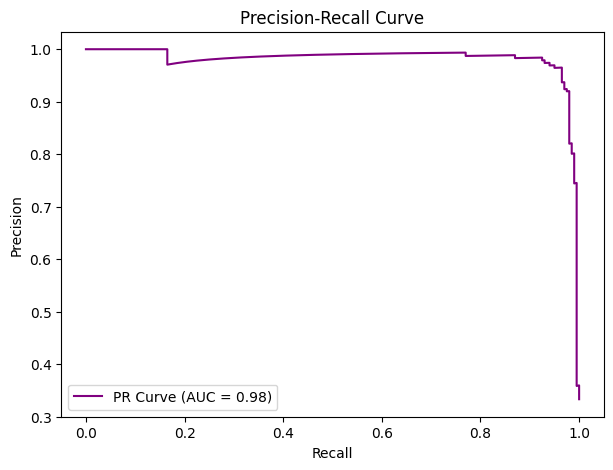

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from mealpy.swarm_based import GWO
from mealpy.utils.problem import Problem
from mealpy.utils.space import IntegerVar, FloatVar

# Create synthetic data
X, y = make_classification(
    n_samples=1000, n_features=100, n_informative=20, n_redundant=10,
    n_classes=3, n_clusters_per_class=1, flip_y=0.03, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_cat = to_categorical(y_train)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Subclass Problem to define custom objective
class KerasHyperparamProblem(Problem):
    def __init__(self):
        problem_vars = [
            IntegerVar(32, 256),
            IntegerVar(32, 256),
            FloatVar(0.1, 0.5),
            IntegerVar(5, 30),
            IntegerVar(16, 64)
        ]
        super().__init__(bounds=problem_vars, minmax="min")

    def obj_func(self, solution):
        n1, n2, drop, epochs, batch = int(solution[0]), int(solution[1]), float(solution[2]), int(solution[3]), int(solution[4])

        model = Sequential([
            Dense(n1, input_shape=(X_train.shape[1],), activation='relu'),
            Dropout(drop),
            Dense(n2, activation='relu'),
            Dense(3, activation='softmax')
        ])

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train_cat, epochs=epochs, batch_size=batch, verbose=0)

        preds = np.argmax(model.predict(X_test), axis=1)
        probs = model.predict(X_test)

        precision = precision_score(y_test, preds, average='weighted')
        recall = recall_score(y_test, preds, average='weighted')
        f1 = f1_score(y_test, preds, average='weighted')
        accuracy = accuracy_score(y_test, preds)

        try:
            auc_score = roc_auc_score(y_test_bin, probs, multi_class='ovr')
        except ValueError:
            auc_score = 0.0

        try:
            precision_pr, recall_pr, _ = precision_recall_curve(y_test_bin.ravel(), probs.ravel())
            pr_auc = np.trapz(recall_pr, precision_pr)
        except:
            pr_auc = 0.0

        score = (accuracy + f1 + auc_score + pr_auc) / 4
        return -score

problem = KerasHyperparamProblem()

model_gwo = GWO.OriginalGWO(
    problem_size=problem.n_dims,
    domain_range=(0, 1),
    print_train=True,
    epoch=5,
    pop_size=6
)

best_agent = model_gwo.solve(problem=problem)
best_position = best_agent.solution
best_score = best_agent.target

print(f"\nBest Parameters Found: {best_position}")

# Build final model
n1, n2, drop, epochs, batch = int(best_position[0]), int(best_position[1]), float(best_position[2]), int(best_position[3]), int(best_position[4])

final_model = Sequential([
    Dense(n1, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(drop),
    Dense(n2, activation='relu'),
    Dense(3, activation='softmax')
])

final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
final_model.fit(X_train, y_train_cat, epochs=epochs, batch_size=batch, verbose=1)

preds = np.argmax(final_model.predict(X_test), axis=1)
probs = final_model.predict(X_test)

accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average='weighted')
recall = recall_score(y_test, preds, average='weighted')
f1 = f1_score(y_test, preds, average='weighted')
auc_value = roc_auc_score(y_test_bin, probs, multi_class='ovr')

print(f"\nFinal Model Metrics:")
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc_value:.4f}")

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7, 5))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (OvR)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

precision_pr, recall_pr, _ = precision_recall_curve(y_test_bin.ravel(), probs.ravel())
pr_auc = auc(recall_pr, precision_pr)

plt.figure(figsize=(7, 5))
plt.plot(recall_pr, precision_pr, color='purple', label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()